## Setup

In [1]:
import yaml
import pathlib
import pickle as pk
from copy import deepcopy

import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import umap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier

import utils
from cplAE_MET.models.model_classes import MultiModal

In [340]:
def get_reconstruction(model, met_data, specimen_ids, in_modal, out_modal, out_exists = False):
    model.eval()
    all_data = met_data.get_specimens(specimen_ids)
    (in_data, out_data) = (all_data[f"{in_modal}_dat"], all_data[f"{out_modal}_dat"])
    valid_in = ~np.isnan(in_data).reshape([in_data.shape[0], -1]).any(1)
    valid_out = (~np.isnan(out_data).reshape([out_data.shape[0], -1]).any(1) if out_exists else valid_in)
    valid_specimens = specimen_ids[valid_in & valid_out]
    modal_data = met_data.get_specimens(valid_specimens)
    recon = model(torch.from_numpy(modal_data[f"{in_modal}_dat"]).float(), in_modal, [out_modal])[1][0].detach().numpy()
    return (recon, modal_data)

def get_latent(model, met_data, specimen_ids, in_modal):
    model.eval()
    in_data = met_data.get_specimens(specimen_ids)[f"{in_modal}_dat"]
    valid_specimens = specimen_ids[~np.isnan(in_data).reshape([in_data.shape[0], -1]).any(1)]
    modal_data = met_data.get_specimens(valid_specimens)
    torch_input = torch.from_numpy(modal_data[f"{in_modal}_dat"]).float()
    latent = model.modal_arms[in_modal].encoder(torch_input).detach().numpy()
    return (latent, modal_data)

def load_all(exp_dir, checkpoint = None):
    experiment = utils.load_experiment(exp_dir)
    data = utils.load_data(experiment)
    state_dict = experiment["checkpoints"][checkpoint] if checkpoint is not None else experiment["best"]
    model = utils.load_model(experiment["config"], state_dict)
    data_dict = {"experiment": experiment, "data": data, "model": model}
    return data_dict
    
def get_pc_cca_baselines(modal_1, modal_2, latent_dim):
    experiment = utils.load_experiment(f"results/{modal_1}_arm")
    data = utils.load_data(experiment)
    train_data = data.query(experiment["train_ids"], [modal_1, modal_2])
    test_data = data.query(experiment["test_ids"], [modal_1, modal_2])
    num_train = len(train_data["specimen_id"])
    x1 = np.concatenate([train_data[f"{modal_1}_dat"], test_data[f"{modal_1}_dat"]])
    x2 = np.concatenate([train_data[f"{modal_2}_dat"], test_data[f"{modal_2}_dat"]])
    (z1, z2, xr1, xr2, xr1_2, xr2_1) = pc_cca(x1.reshape([x1.shape[0], -1]), x2.reshape([x2.shape[0], -1]), 
                                                np.arange(num_train), 50, 50, latent_dim)
    train_results = (z1[:num_train], z2[:num_train], xr1[:num_train], xr2[:num_train], xr1_2[:num_train], xr2_1[:num_train])
    test_results = (z1[num_train:], z2[num_train:], xr1[num_train:], xr2[num_train:], xr1_2[num_train:], xr2_1[num_train:])
    return ((train_results, train_data), (test_results, test_data))

def get_r2_scores(exp_recon_dict):
    scores = {}
    for (modal_string, (recon, modal_data)) in exp_recon_dict.items():
        out_modal = modal_string.split("->")[1]
        num_samples = recon.shape[0]
        orig_flat = modal_data[f"{out_modal}_dat"].reshape(num_samples, -1)
        recon_flat = recon.reshape(num_samples, -1)
        scores[modal_string] = r2_score(orig_flat, recon_flat)
    return scores

In [327]:
from sklearn.cross_decomposition import CCA
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from scipy.linalg import sqrtm

class CCA_extended(CCA):
  
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        return
      
    def inverse_transform_xy(self,X,Y):
        """
        This module calculates the inverse transform for both X and Y
        CCA.inverse_transform module only calculates reconstructions for X
        """
        check_is_fitted(self)
        X = check_array(X, dtype=FLOAT_DTYPES)
        Y = check_array(Y, dtype=FLOAT_DTYPES)
        
        x = np.matmul(X, self.x_loadings_.T)
        x *= self._x_std
        x += self._x_mean
        
        y = np.matmul(Y, self.y_loadings_.T)
        y *= self._y_std
        y += self._y_mean
        return x,y

def pc_cca(XT, XE, train_ind, pc_dim_T, pc_dim_E, cca_dim):
    """Reduce dimensionality of XT and XE with PCA, and then obtained an co-ordinated representations with CCA.

    Args:
        XT: numpy arrays cells x features
        XE: numpy arrays cells x features
        train_ind: Principle components and canonical components are obtained with this set of cells. 
        pc_dim_T (int): Numper of principle components for XT
        pc_dim_E (int): Numper of principle components for XE
        cca_dim (int): shared space dimensionality

    Returns:
        zT_white: zT is centered and transformed to have unit diagonal covariance (whitening transformation)
        zE_white: zE is centered and transformed to have unit diagonal covariance (whitening transformation)
        XrT
        XrE
        XrT_from_XE
        XrE_from_XT
    """

    XT = deepcopy(XT)
    XE = deepcopy(XE)

    #Reduce dims of T data
    if pc_dim_T is not None:
        pcaT = PCA(n_components=pc_dim_T)
        pcaT.fit_transform(XT[train_ind, :])
        XTpc = pcaT.transform(XT)
    else:
        XTpc = XT

    #Reduce dims of E data
    if pc_dim_E is not None:
        pcaE = PCA(n_components=pc_dim_E)
        pcaE.fit_transform(XE[train_ind, :])
        XEpc = pcaE.transform(XE)
    else:
        XEpc = XE

    #CCA on T and E data
    cca = CCA_extended(n_components=cca_dim, scale=True, max_iter=10000, tol=1e-06, copy=True)
    cca.fit(XTpc[train_ind, :], XEpc[train_ind, :])
    zT, zE = cca.transform(XTpc, XEpc)

    zT_white = zT - np.mean(zT, axis=0)
    zT_white = np.matmul(zT_white, sqrtm(
        np.linalg.inv(np.cov(np.transpose(zT_white)))))

    zE_white = zE - np.mean(zE, axis=0)
    zE_white = np.matmul(zE_white, sqrtm(
        np.linalg.inv(np.cov(np.transpose(zE_white)))))

    #Within modality reconstruction
    XrTpc, XrEpc = cca.inverse_transform_xy(zT, zE)
    XrT = pcaT.inverse_transform(XrTpc)
    XrE = pcaE.inverse_transform(XrEpc)

    #Cross modality reconstruction
    XrTpc_from_zE, XrEpc_from_zT = cca.inverse_transform_xy(zE, zT)
    XrT_from_XE = pcaT.inverse_transform(XrTpc_from_zE)
    XrE_from_XT = pcaE.inverse_transform(XrEpc_from_zT)

    return zT_white, zE_white, XrT, XrE, XrT_from_XE, XrE_from_XT

## Models

In [328]:
model_paths = ["baselines/t_arm", "baselines/e_arm", "baselines/m_arm", "baselines/t_e_arms", "baselines/t_m_arms", "baselines/e_m_arms",
              "met/improved"]
model_data = {path.split("/")[-1]: load_all(path) for path in model_paths}

In [357]:
met = model_data["m_arm"]["data"]

In [360]:
Xm = met.query(modalities = ["M"])["M_dat"]

In [362]:
Xm.shape

(45801, 120, 4, 4)

In [380]:
pca = PCA(0.99).fit(Xm.reshape([Xm.shape[0], -1]))

In [381]:
z = pca.explained_variance_ratio_

In [382]:
pca.components_.shape

(187, 1920)

## Within- and Cross-modality Reconstruction

### PCA-CCA Baselines

In [214]:
cca_results = {}
modalities = ["T", "E", "M"]
for i in range(3):
    for j in range(i + 1, 3):
        (modal_1, modal_2) = (modalities[i], modalities[j])
        print(f"{modal_1}-{modal_2}", end = "\r")
        cca_results[f"{modal_1}-{modal_2}"] = get_pc_cca_baselines(modal_1, modal_2, 3)
print("Complete")

Complete


In [215]:
for (key, cca_data) in cca_results.items():
    (modal_1, modal_2) = key.split("-")
    ((_, _, xr1, xr2, xr1_2, xr2_1), data_dict) = cca_data[1]
    (x1, x2) = (data_dict[f"{modal_1}_dat"], data_dict[f"{modal_2}_dat"])
    score1 = r2_score(x1.reshape([x1.shape[0], -1]), xr1)
    score2 = r2_score(x2.reshape([x2.shape[0], -1]), xr2)
    score1_2 = r2_score(x1.reshape([x1.shape[0], -1]), xr1_2)
    score2_1 = r2_score(x2.reshape([x2.shape[0], -1]), xr2_1)
    print(f"{modal_1}->{modal_1}: {score1:.2f} | {modal_2}->{modal_2}: {score2:.2f} | {modal_2}->{modal_1}: {score1_2:.2f} | {modal_1}->{modal_2}: {score2_1:.2f}")

T->T: 0.15 | E->E: 0.25 | E->T: 0.13 | T->E: 0.22
T->T: 0.15 | M->M: 0.20 | M->T: 0.14 | T->M: 0.20
E->E: 0.19 | M->M: 0.18 | M->E: 0.12 | E->M: 0.16


In [260]:
get_reconstruction(
                model_data["improved"]["model"], model_data["improved"]["data"], model_data["improved"]["experiment"]["test_ids"], 
                "T", "T", out_exists = True)

(array([[0.0010368 , 0.01113251, 0.09850567, ..., 0.        , 0.05154305,
         0.03287008],
        [0.01711858, 0.01425684, 0.1016603 , ..., 0.        , 0.03977181,
         0.02430153],
        [0.0065862 , 0.00341309, 0.08882773, ..., 0.        , 0.04935455,
         0.        ],
        ...,
        [0.01657113, 0.01586241, 0.08698437, ..., 0.        , 0.04623136,
         0.        ],
        [0.02162886, 0.01972665, 0.08025252, ..., 0.        , 0.05362458,
         0.        ],
        [0.00253932, 0.00822429, 0.07864813, ..., 0.        , 0.06162247,
         0.        ]], dtype=float32),
 {'E_dat': array([[-6.35369381e-01,  6.07346873e-01,  3.16851890e-01, ...,
          -1.09912884e+00,  7.01424447e-01,  2.94811565e+00],
         [ 1.88726954e+00,  9.01620626e-01,  8.60276532e-01, ...,
           1.53623946e+00, -4.94176751e-01,  9.02999281e-01],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
 

In [263]:
recons["improved"]["E->T"]

(array([[0.00935109, 0.00558388, 0.09221023, ..., 0.        , 0.04619811,
         0.0048524 ],
        [0.02492446, 0.02556325, 0.11414681, ..., 0.        , 0.04308658,
         0.02769797],
        [0.02505615, 0.02217185, 0.10372144, ..., 0.        , 0.03578753,
         0.00659829],
        ...,
        [0.02727122, 0.02591157, 0.10785782, ..., 0.        , 0.03556887,
         0.01136445],
        [0.02849072, 0.02703756, 0.1084787 , ..., 0.        , 0.03611308,
         0.00805782],
        [0.01664256, 0.01424797, 0.10140733, ..., 0.        , 0.04517164,
         0.01593176]], dtype=float32),
 {'E_dat': array([[-6.35369381e-01,  6.07346873e-01,  3.16851890e-01, ...,
          -1.09912884e+00,  7.01424447e-01,  2.94811565e+00],
         [ 1.88726954e+00,  9.01620626e-01,  8.60276532e-01, ...,
           1.53623946e+00, -4.94176751e-01,  9.02999281e-01],
         [-8.98388450e-01,  1.03652758e-01,  1.25182939e-01, ...,
          -1.00030253e+00,  5.58988591e-01,  1.12060926e+00],
 

### Autoencoders

In [267]:
recons = {}
for (exp_name, exp_dict) in model_data.items():
    recons[exp_name] = {}
    modalities = exp_dict["model"].modal_arms.keys()
    for in_modal in modalities:
        for out_modal in modalities:
            print(f"Generating {exp_name}: {in_modal} -> {out_modal}", end = "\r") 
            (recon, modal_data) = get_reconstruction(
                exp_dict["model"], exp_dict["data"], exp_dict["experiment"]["test_ids"], in_modal, out_modal,
                out_exists = True)
            recons[exp_name][f"{in_modal}->{out_modal}"] = (recon, modal_data)
print("Complete                      ")

Complete                      


In [268]:
r2_scores = {exp_name: get_r2_scores(recon_dict) for (exp_name, recon_dict) in recons.items()}

In [269]:
modal_pairs = ["TT", "ET", "MT", "EE", "TE", "ME", "MM", "TM", "EM"]
within_r2 = {f"{modal_1}->{modal_2}": {} for (modal_1, modal_2) in modal_pairs}
for (exp_name, r2_dict) in r2_scores.items():
    for (modal_string, within_dict) in within_r2.items():
        score = r2_dict.get(modal_string)
        within_dict[exp_name] = score
pd.DataFrame(within_r2)

,T->T,E->T,M->T,E->E,T->E,M->E,M->M,T->M,E->M
t_arm,0.346507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_arm,NaN,NaN,NaN,0.540520,NaN,NaN,NaN,NaN,NaN
m_arm,NaN,NaN,NaN,NaN,NaN,NaN,0.214244,NaN,NaN
t_e_arms,0.322139,0.161358,NaN,0.531060,0.228955,NaN,NaN,NaN,NaN
t_m_arms,0.200683,NaN,0.052715,NaN,NaN,NaN,0.118065,0.254667,NaN
e_m_arms,NaN,NaN,NaN,0.406553,NaN,-0.011050,0.139449,NaN,0.212536
improved,0.268813,0.192652,0.077703,0.428603,0.267158,0.051209,0.183262,0.232772,0.195095


### Cross-modality Reconstruction

### Unimodal Baselines

In [50]:
t_r2 = get_baseline("T")
e_r2 = get_baseline("E")
m_r2 = get_baseline("M")
print(f"R2 Score -- T: {t_r2:.2f} | E: {e_r2:.2f} | M: {m_r2:.2f}")

R2 Score -- T: 0.36 | E: 0.53 | M: 0.26


### PCA-CCA Baselines

In [214]:
cca_results = {}
modalities = ["T", "E", "M"]
for i in range(3):
    for j in range(i + 1, 3):
        (modal_1, modal_2) = (modalities[i], modalities[j])
        print(f"{modal_1}-{modal_2}", end = "\r")
        cca_results[f"{modal_1}-{modal_2}"] = get_pc_cca_baselines(modal_1, modal_2, 3)
print("Complete")

Complete


In [215]:
for (key, cca_data) in cca_results.items():
    (modal_1, modal_2) = key.split("-")
    ((_, _, xr1, xr2, xr1_2, xr2_1), data_dict) = cca_data[1]
    (x1, x2) = (data_dict[f"{modal_1}_dat"], data_dict[f"{modal_2}_dat"])
    score1 = r2_score(x1.reshape([x1.shape[0], -1]), xr1)
    score2 = r2_score(x2.reshape([x2.shape[0], -1]), xr2)
    score1_2 = r2_score(x1.reshape([x1.shape[0], -1]), xr1_2)
    score2_1 = r2_score(x2.reshape([x2.shape[0], -1]), xr2_1)
    print(f"{modal_1}->{modal_1}: {score1:.2f} | {modal_2}->{modal_2}: {score2:.2f} | {modal_2}->{modal_1}: {score1_2:.2f} | {modal_1}->{modal_2}: {score2_1:.2f}")

T->T: 0.15 | E->E: 0.25 | E->T: 0.13 | T->E: 0.22
T->T: 0.15 | M->M: 0.20 | M->T: 0.14 | T->M: 0.20
E->E: 0.19 | M->M: 0.18 | M->E: 0.12 | E->M: 0.16


### Coupled Auto-Encoder

In [353]:
(coupled_experiment, coupled_data, coupled_model) = list(load_all(f"baselines/E_arm", 100).values())

In [354]:
recons = {}
modal = coupled_model.modal_arms.keys()
for in_modal in modal:
    for out_modal in modal:
        recons[f"{in_modal}-{out_modal}"] = get_reconstruction(
            coupled_model, coupled_data, coupled_experiment["test_ids"], in_modal, out_modal, True)

In [355]:
scores = {}
for (key, (recon, modal_data)) in recons.items():
    original = modal_data[f"{key.split('-')[1]}_dat"]
    score = r2_score(original.reshape(recon.shape[0], -1), recon.reshape(recon.shape[0], -1))
    scores[key] = score

In [356]:
modalities = ["T", "E", "M"]
print("Reconstruction R2 Scores")
for in_modal in modalities:
    print(" | ".join([f"{in_modal}->{out_modal}: {scores[f'{in_modal}-{out_modal}']:.2f}"
                      for out_modal in modalities if f'{in_modal}-{out_modal}' in scores]))
    

# print(f"T->T: {scores['T-T']:.2f} | T->E: {scores['T-E']:.2f} | T->M: {scores['T-M']:.2f}")
# print(f"E->T: {scores['E-T']:.2f} | E->E: {scores['E-E']:.2f} | E->M: {scores['E-M']:.2f}")
# print(f"M->T: {scores['M-T']:.2f} | M->E: {scores['M-E']:.2f} | M->M: {scores['M-M']:.2f}")

Reconstruction R2 Scores

E->E: 0.47



## Latent Spaces

### Unimodal Baseline

In [39]:
baselines = {"X": [], "Y": [], "Modality": [], "Types": []}
for modal in ["T", "E", "M"]:
    (exp, data, model) = load_all(f"results/{modal}_arm")
    (latent, modal_data) = get_latent(model, data, exp["test_ids"], modal)
    labeled = ~np.isnan(modal_data["cluster_id"])
    proj = PCA(n_components = 2).fit_transform(latent)
    baselines["X"].append(proj[:, 0][labeled])
    baselines["Y"].append(proj[:, 1][labeled])
    baselines["Modality"].append(np.full([proj[labeled].shape[0]], modal))
    baselines["Types"].append(modal_data["merged_cluster_label_at80"][labeled])
baselines = {key: np.concatenate(arr_list) for (key, arr_list) in baselines.items()}

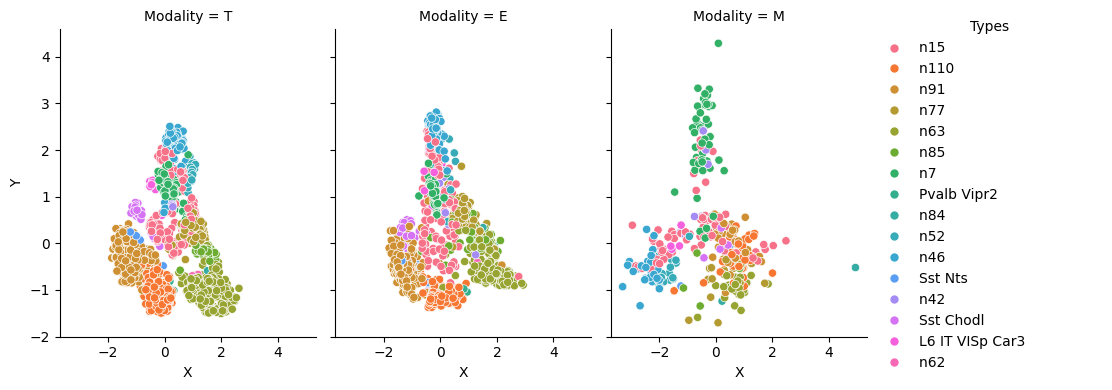

In [44]:
plot = sns.relplot(data = baselines, x = "X", y = "Y", col = "Modality", hue = "Types", height=4, aspect= 0.75)
plt.show()

### Coupled Auto-Encoder

In [334]:
latent_data = {modal: get_latent(coupled_model, coupled_data, coupled_experiment["test_ids"], modal)
               for modal in ["T", "E", "M"]}

KeyError: 'T'

In [ ]:
pca_all = PCA(n_components = 2).fit(np.concatenate([latent_data["T"][0], latent_data["E"][0], latent_data["M"][0]]))

In [ ]:
met_specimens = coupled_data.query(coupled_experiment["test_ids"], ["M", "E", "T"])["specimen_id"]
coupled_results = {"X": [], "Y": [], "Modality": [], "Types": []}
for modal in ["T", "E", "M"]:
    (latent, modal_data) = latent_data[modal]
    labeled = ~np.isnan(modal_data["cluster_id"]) & np.isin(modal_data["specimen_id"], met_specimens)
    proj = pca_all.transform(latent)
    coupled_results["X"].append(proj[:, 0][labeled])
    coupled_results["Y"].append(proj[:, 1][labeled])
    coupled_results["Modality"].append(np.full([proj[labeled].shape[0]], modal))
    coupled_results["Types"].append(modal_data["merged_cluster_label_at80"][labeled])
coupled_results = {key: np.concatenate(arr_list) for (key, arr_list) in coupled_results.items()}

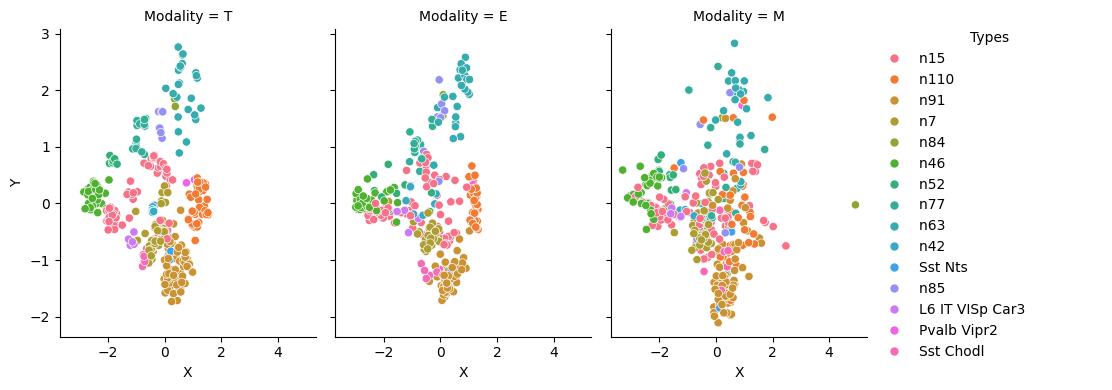

In [15]:
plot = sns.relplot(data = coupled_results, x = "X", y = "Y", col = "Modality", hue = "Types", height = 4, aspect = 0.75)
plt.show()

## Classification

In [265]:
count_thresh = 6
results = {"num_classes": [], "acc": [], "modal": [], "model": []}
cca_keys = {"T": "T-E", "E": "T-E", "M": "T-M"}
for modal in ["T", "E", "M"]:
    train_data = coupled_data.query(coupled_experiment["train_ids"], ["T"] + [modal])
    test_data = coupled_data.query(coupled_experiment["test_ids"], ["T"] + [modal])
    for val in range(40, 100, 10):
        print(f"Processing {modal} at {val}", end = "\r")
        (labels, counts) = np.unique(train_data[f"merged_cluster_label_at{val}"], return_counts = True)
        valid_samples = np.isin(train_data[f"merged_cluster_label_at{val}"], labels[counts > count_thresh])
        valid_specimens = train_data["specimen_id"][valid_samples]
        train_x = get_latent(coupled_model, coupled_data, valid_specimens, modal)[0]
        train_y = train_data[f"merged_cluster_label_at{val}"][valid_samples]

        valid_test = np.isin(test_data[f"merged_cluster_label_at{val}"], train_y)
        valid_test_specimens = test_data["specimen_id"][valid_test]
        test_x = get_latent(coupled_model, coupled_data, valid_test_specimens, modal)[0]
        test_y = test_data[f"merged_cluster_label_at{val}"][valid_test]

        qda = QDA(reg_param=1e-2, store_covariance=True).fit(train_x, train_y)
        (train_score, test_score) = (qda.score(train_x, train_y), qda.score(test_x, test_y))
        dummy = DummyClassifier(strategy = "most_frequent").fit(train_x, train_y)
        baseline_score = dummy.score(test_x, test_y)

        ((cca_train_out, cca_train_data), (cca_test_out, cca_test_data)) = cca_results[cca_keys[modal]]
        valid_train_cca = np.isin(cca_train_data["specimen_id"], valid_specimens)
        valid_test_cca = np.isin(cca_test_data["specimen_id"], valid_test_specimens)
        
        cca_train_x = cca_train_out[0 if modal == "T" else 1][valid_train_cca]
        cca_train_y = cca_train_data[f"merged_cluster_label_at{val}"][valid_train_cca]
        cca_test_x = cca_test_out[0 if modal == "T" else 1][valid_test_cca]
        cca_test_y = cca_test_data[f"merged_cluster_label_at{val}"][valid_test_cca]
        qda_cca = QDA(reg_param=1e-2, store_covariance=True).fit(cca_train_x, cca_train_y)
        cca_score = qda_cca.score(cca_test_x, cca_test_y)
        
        results["num_classes"].append(np.sum(counts > count_thresh))
        results["acc"].append(train_score)
        results["modal"].append(modal)
        results["model"].append("train")

        results["num_classes"].append(np.sum(counts > count_thresh))
        results["acc"].append(test_score)
        results["modal"].append(modal)
        results["model"].append("test")

        results["num_classes"].append(np.sum(counts > count_thresh))
        results["acc"].append(cca_score)
        results["modal"].append(modal)
        results["model"].append("PCA-CCA")
        
        results["num_classes"].append(np.sum(counts > count_thresh))
        results["acc"].append(baseline_score)
        results["modal"].append(modal)
        results["model"].append("guessing")
print("Completed")
results = {key: np.asarray(arr_list) for (key, arr_list) in results.items()}

Completedg M at 90


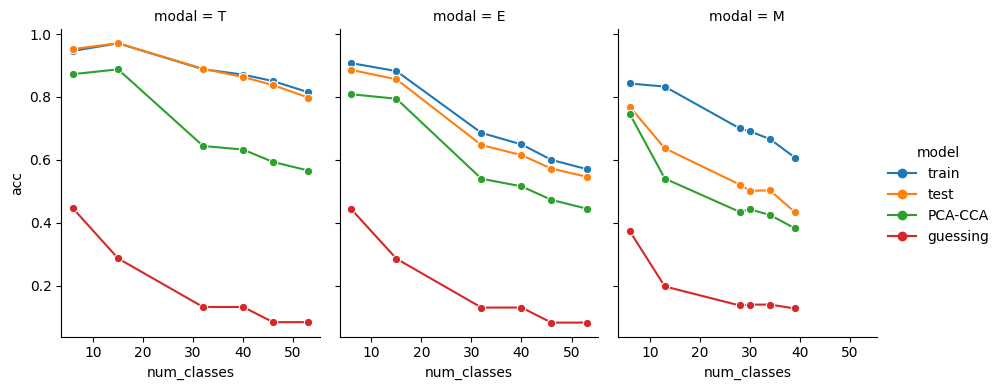

T
6: 95.18 | 15: 97.07 | 32: 88.94 | 40: 86.30 | 46: 83.73 | 53: 79.79
E
6: 88.55 | 15: 85.58 | 32: 64.67 | 40: 61.48 | 46: 57.18 | 53: 54.62
M
6: 76.86 | 13: 63.64 | 28: 52.11 | 30: 50.13 | 34: 50.27 | 39: 43.36


In [266]:
sns.relplot(data = results, x = "num_classes", y = "acc", hue = "model", col = "modal", kind = "line", marker = "o",
            height = 4, aspect = 0.75)
plt.show()

for modal in ["T", "E", "M"]:
    mask = (results["modal"] == modal) & (results["model"] == "test")
    num_classes = results["num_classes"][mask]
    scores = results["acc"][mask]
    print(modal)
    print(" | ".join(reversed([f"{val}: {100*acc:.2f}" for (val, acc) in zip(num_classes, scores)])))